# RGB画像からのポットの抽出

In [45]:
import cv2
import numpy as np

In [46]:
im = cv2.imread('../data/2021-03-31T21-36-57.552768_color_image.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [47]:
import matplotlib.pyplot as plt

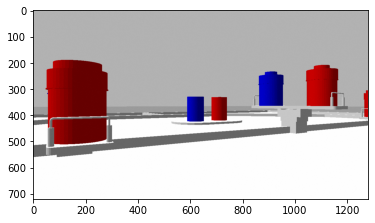

In [48]:
plt.imshow(im)
plt.show()

# RGBからHSVへ変換, 赤色の抽出

In [49]:
hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV_FULL)
h = hsv[:, :, 0]
s = hsv[:, :, 1]

Hue(色相), Saturation(彩度)より赤色領域をマスク

In [50]:
mask = np.zeros(h.shape, dtype=np.uint8)
mask[((h < 20) | (h > 200)) & (s > 128)] = 255

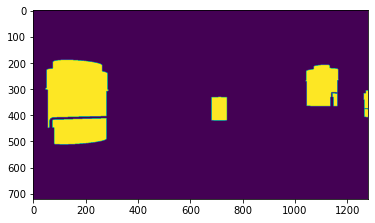

In [51]:
plt.imshow(mask)
plt.show()

# 膨張、収縮処理によりポールを消す

In [52]:
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(25,25))
mask = cv2.dilate(mask,kernel,iterations = 1)
mask = cv2.erode(mask,kernel,iterations = 1)

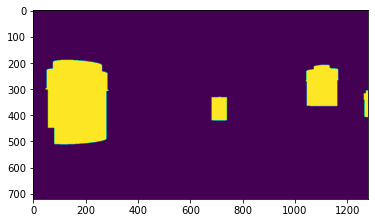

In [53]:
plt.imshow(mask)
plt.show()

フィルタサイズによって消せるポールのサイズは変化する。
また、この処理によって隣接するポットが結合してしまうことも

# マスク領域の輪郭を抽出

In [54]:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

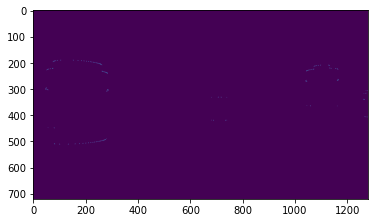

In [55]:
display = np.zeros(mask.shape, dtype=np.uint8)
for c in contours:
    for elem in c:
        display[elem[0,1],elem[0,0]]=255
plt.imshow(display)
plt.show()

# 輪郭を凸包で囲み、凸包を囲む矩形領域を抽出

In [56]:
rects = []
for contour in contours:
    approx = cv2.convexHull(contour)
    rect = cv2.boundingRect(approx)
    rects.append(rect)

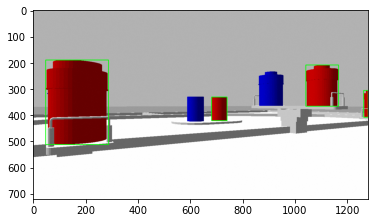

In [57]:
for rect in rects:
    x, y, w, h = rect
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), thickness=2)
plt.imshow(im)
plt.show()

Depth画像ではこの矩形領域内を探索する

# Depth画像からポットの位置を推定

読み込み

In [58]:
#dep = cv2.imread('../data/2021-03-23T00-16-59.366620_depth_image.tiff')
dep = np.load("../data/2021-03-31T21-36-57.576928_depth_image.npy")

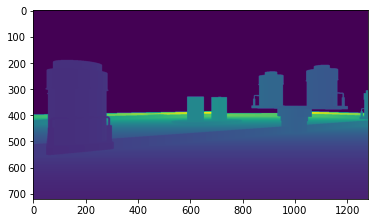

In [59]:
plt.imshow(dep)
plt.show()

BoundingBoxの表示

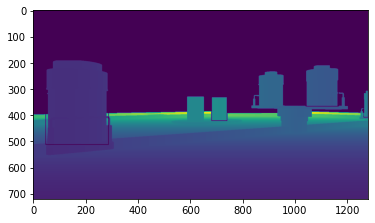

In [60]:
dep_cp = dep.copy()
for rect in rects:
    x, y, w, h = rect
    cv2.rectangle(dep_cp, (x, y), (x + w, y + h), (0, 255, 0), thickness=2)
plt.imshow(dep_cp)
plt.show()

一案
- BBox内で最も距離が近い点を行ごとに探索
その点とロボット位置の直線上にポット中心があるはず

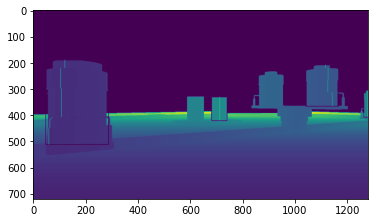

In [61]:
#table = np.zeros_like(dep)
im_cp = im.copy()
for rect in rects:
    x, y, w, h = rect
    for i in range(y,y+h):
        res = 1e9
        for j in range(x,x+w):
            if res > dep[i][j] and dep[i][j]!=0:
                res = dep[i][j]
                max_x_ind = j
            #table[i][j]=255
        dep_cp[i][max_x_ind] = 10000

        im_cp[i][max_x_ind] = [255,255,0]

plt.imshow(dep_cp)
plt.show()

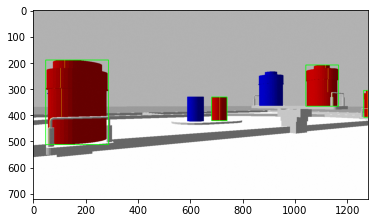

In [62]:
plt.imshow(im_cp)
plt.show()

案の仮説はあっているのか？<br>
あと、ポールが邪魔しているので、中央値をとるなどマスキングしてみるか

他の案
- BBoxの中心軸とロボットの位置の直線状にポットの中心があると仮定する<br>
BBoxの中心軸上の距離の中央値+ポットの半径値(既知)よりロボットからポット中心までの距離を推定

他にも案があったら教えてほしい！＆サクッと実装して確認してみてほしい